In [1]:
from skimage.io import imread
from sklearn.neighbors import KDTree
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os
sys.path.insert(0, '../../../../FISH-annotation/fishanno')
import util
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation

### Parameters

In [2]:
cwd = os.getcwd()
clustering_params = ['AffinityPropagation', -350]

background_list = ['cells', 'tissue']
nspots_list = [50, 100, 150]
spot_sig = 1.75
snr_list = [5, 10, 20]

### Get clusters pre and post QC

In [3]:
clusters_pre_and_post_qc = []
for background in background_list:
    json_filename = 'SynthData_cells.json' if background == 'cells' else 'SynthTests_tissue.json'
    json_filepath = '%s/datasets/SynthTest/%s' % (cwd, json_filename)
    prefix = 'MAX_C3-ISP_300_1_' if background == 'cells' else 'MAX_ISP_300_1_'
    
    for nspots in nspots_list:
        for snr in snr_list:
            
            # read annotations
            name = '%snspots%s_spot_sig%s_snr%s_2.5' % (prefix, nspots, spot_sig, snr)
            img_filename = '%s_spot_img.png' % (name)
            csv_filename = '%s_coord_snr_list.csv' % (name)
            img_filepath = cwd + '/datasets/SynthTest/spot_images/%s/%s' % (background, img_filename)
            csv_filepath = cwd + '/datasets/SynthTest/spot_data/%s/%s' % (background, csv_filename)
            
            print('Now processing %s' % (img_filename))
            
            qa = QuantiusAnnotation(json_filepath, img_filename)
            sa = SpotAnnotationAnalysis(qa)
            anno_all = qa.df()
            
            # cluster annotations
            clusters_pre_qc = sa.get_clusters(anno_all, clustering_params)            

            # threshold clusters by number of annotations
            cluster_size_threshold = util.get_cluster_size_threshold(clusters_pre_qc)
            small_clusters, large_clusters = util.sort_clusters_by_size(clusters_pre_qc, cluster_size_threshold)
        
            clusters_post_qc = large_clusters        
            clusters_pre_and_post_qc.append((img_filename, img_filepath, csv_filename, csv_filepath, clusters_pre_qc, clusters_post_qc))
            

Now processing MAX_C3-ISP_300_1_nspots50_spot_sig1.75_snr5_2.5_spot_img.png


../../../../FISH-annotation/Annotation/util.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())			# get the list of occasions
../../../../FISH-annotation/Annotation/util.py:74: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


Now processing MAX_C3-ISP_300_1_nspots50_spot_sig1.75_snr10_2.5_spot_img.png
Now processing MAX_C3-ISP_300_1_nspots50_spot_sig1.75_snr20_2.5_spot_img.png
Now processing MAX_C3-ISP_300_1_nspots100_spot_sig1.75_snr5_2.5_spot_img.png
Now processing MAX_C3-ISP_300_1_nspots100_spot_sig1.75_snr10_2.5_spot_img.png
Now processing MAX_C3-ISP_300_1_nspots100_spot_sig1.75_snr20_2.5_spot_img.png
Now processing MAX_C3-ISP_300_1_nspots150_spot_sig1.75_snr5_2.5_spot_img.png
Now processing MAX_C3-ISP_300_1_nspots150_spot_sig1.75_snr10_2.5_spot_img.png
Now processing MAX_C3-ISP_300_1_nspots150_spot_sig1.75_snr20_2.5_spot_img.png
Now processing MAX_ISP_300_1_nspots50_spot_sig1.75_snr5_2.5_spot_img.png
Now processing MAX_ISP_300_1_nspots50_spot_sig1.75_snr10_2.5_spot_img.png
Now processing MAX_ISP_300_1_nspots50_spot_sig1.75_snr20_2.5_spot_img.png
Now processing MAX_ISP_300_1_nspots100_spot_sig1.75_snr5_2.5_spot_img.png
Now processing MAX_ISP_300_1_nspots100_spot_sig1.75_snr10_2.5_spot_img.png
Now proces

### Save consensus centroids

In [4]:
os.mkdir('datasets/SynthTest/clusters')
os.mkdir('datasets/SynthTest/clusters/pre_qc')
os.mkdir('datasets/SynthTest/clusters/post_qc')

In [5]:
for img_filename, img_filepath, csv_filename, csv_filepath, clusters_pre_qc, clusters_post_qc in clusters_pre_and_post_qc:
    im = imread(img_filepath)
    img_height = len(im)
    
    clusters_pre_qc_list = []
    for index in clusters_pre_qc.index:
        row = clusters_pre_qc.iloc[index]
        x, y = row['centroid_x'], row['centroid_y']
        clusters_pre_qc_list.append([x, img_height-y])
    path = 'datasets/SynthTest/clusters/pre_qc/%s' % (csv_filename)
    np.savetxt(path, np.asarray(clusters_pre_qc_list), delimiter=",", comments='', header='centroid_x,centroid_y')

    clusters_post_qc_list = []
    for index in clusters_post_qc.index:
        row = clusters_post_qc.iloc[index]
        x, y = row['centroid_x'], row['centroid_y']
        clusters_post_qc_list.append([x, img_height-y])
    path = 'datasets/SynthTest/clusters/post_qc/%s' % (csv_filename)
    np.savetxt(path, np.asarray(clusters_post_qc_list), delimiter=",", comments='', header='centroid_x,centroid_y')
    

### Calculate precision and recall: consensus annotations vs. reference annotations

In [6]:
correctness_threshold = 4

In [7]:
sort_list, precision_list, recall_list = [], [], []
for csv_filename in os.listdir('%s/datasets/SynthTest/clusters/pre_qc' % (cwd)):
    
    consensus_filepaths = ['%s/datasets/SynthTest/clusters/pre_qc/%s' % (cwd, csv_filename),
                           '%s/datasets/SynthTest/clusters/post_qc/%s' % (cwd, csv_filename)]
    for consensus_filepath in consensus_filepaths:
    
        consensus_coords = np.asarray(pd.read_csv(consensus_filepath))
        consensus_kdt = KDTree(consensus_coords, leaf_size=2, metric='euclidean')

        if csv_filename.startswith('MAX_ISP'):
            reference_filepath = '%s/datasets/SynthTest/spot_data/tissue/%s' % (cwd, csv_filename)
        else:
            reference_filepath = '%s/datasets/SynthTest/spot_data/cells/%s' % (cwd, csv_filename)
        reference_coords = np.asarray(pd.read_csv(reference_filepath))[:,:2]
        reference_kdt = KDTree(reference_coords, leaf_size=2, metric='euclidean')

        correct_consensus = []
        incorrect_consensus = []
        detected_reference = []
        undetected_reference = []

        # correct vs. incorrect

        for consensus_coord in consensus_coords:
            dist, ind = reference_kdt.query([consensus_coord], k=1)
            if dist[0][0] < correctness_threshold:
                correct_consensus.append(consensus_coord)
            else:
                incorrect_consensus.append(consensus_coord)

        # detected vs. undetected

        for reference_coord in reference_coords:
            dist, ind = consensus_kdt.query([reference_coord], k=1)
            if dist[0][0] < correctness_threshold:
                detected_reference.append(reference_coord)
            else:
                undetected_reference.append(reference_coord)
        
        np.savetxt(consensus_filepath.replace('.csv','_correct_consensus.csv'), np.asarray(correct_consensus), delimiter=",", comments='', header='centroid_x,centroid_y')
        np.savetxt(consensus_filepath.replace('.csv','_incorrect_consensus.csv'), np.asarray(incorrect_consensus), delimiter=",", comments='', header='centroid_x,centroid_y')
        np.savetxt(consensus_filepath.replace('.csv','_detected_reference.csv'), np.asarray(detected_reference), delimiter=",", comments='', header='centroid_x,centroid_y')
        np.savetxt(consensus_filepath.replace('.csv','_undetected_reference.csv'), np.asarray(undetected_reference), delimiter=",", comments='', header='centroid_x,centroid_y')
        

For each image, calculate and save
- precision
- recall
- mean snr
- mean nnd

In [8]:
# for each image
for csv_filename in os.listdir('%s/datasets/SynthTest/clusters/pre_qc' % (cwd)):
    
    if csv_filename.endswith('_coord_snr_list.csv'):
        consensus_filepaths = ['%s/datasets/SynthTest/clusters/pre_qc/%s' % (cwd, csv_filename),
                               '%s/datasets/SynthTest/clusters/post_qc/%s' % (cwd, csv_filename)]

        # pre-qc and post-qc data
        for consensus_filepath in consensus_filepaths:

            prec_rec_snr_nnd_list = []
            correct_consensus_path = consensus_filepath.replace('.csv','_correct_consensus.csv')
            incorrect_consensus_path = consensus_filepath.replace('.csv','_incorrect_consensus.csv')
            detected_reference_path = consensus_filepath.replace('.csv','_detected_reference.csv')
            undetected_reference_path = consensus_filepath.replace('.csv','_undetected_reference.csv')

            prec_rec_snr_nnd_path = consensus_filepath.replace('.csv','_prec_rec_snr_nnd.csv')

            num_correct = len(np.asarray(pd.read_csv(correct_consensus_path)))
            num_incorrect = len(np.asarray(pd.read_csv(incorrect_consensus_path)))
            num_detected = len(np.asarray(pd.read_csv(detected_reference_path)))
            num_undetected = len(np.asarray(pd.read_csv(undetected_reference_path)))

            precision = num_correct / (num_correct + num_incorrect)
            recall = num_detected / (num_detected + num_undetected)

            # from filename, get mean snr and reference filepath
            if csv_filename.startswith('MAX_ISP'):
                identity = csv_filename.split('MAX_ISP_300_1_')[1]
                mean_snr = int(identity.split('_')[3].split('snr')[1])
                reference_filepath = '%s/datasets/SynthTest/spot_data/tissue/%s' % (cwd, csv_filename)
            else:
                mean_snr = int(csv_filename.split('MAX_C3-ISP_300_1_')[1].split('_')[3].split('snr')[1])
                reference_filepath = '%s/datasets/SynthTest/spot_data/cells/%s' % (cwd, csv_filename)
            
            # get mean_nnd
            reference_coords = np.asarray(pd.read_csv(reference_filepath))[:,:2]
            reference_kdt = KDTree(reference_coords, leaf_size=2, metric='euclidean')
            nnd_list = []
            for reference_coord in reference_coords:
                dist, ind = reference_kdt.query([reference_coord], k=2)
                nnd_list.append(dist[0][1])
            mean_nnd = np.mean(nnd_list)
            
            prec_rec_snr_nnd_list.append([precision, recall, mean_snr, mean_nnd])
            np.savetxt(prec_rec_snr_nnd_path, np.asarray(prec_rec_snr_nnd_list), delimiter=",", comments='', header='precision,recall,snr,nnd')
            

## Plot precision and recall for raw clusters ("Pre-QC") and after thresholding by number of clusters ("Post-QC")

In [4]:
cm = 'plasma_r'


--------------
Cell Background
--------------


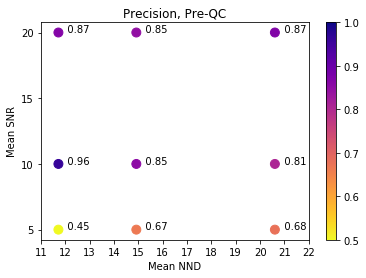

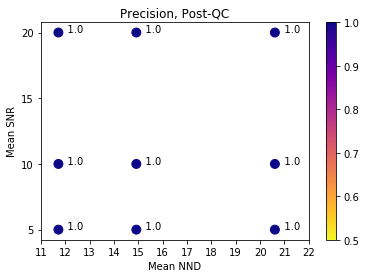

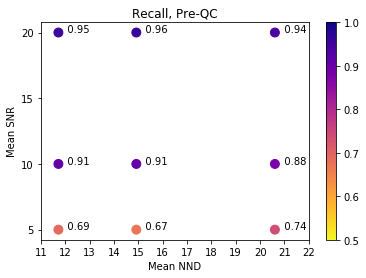

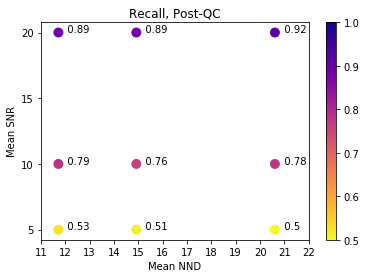

mean_precision_pre_qc_snr5 = 0.6
mean_precision_post_qc_snr5 = 1.0
mean_precision_delta_snr5 = 0.4

mean_recall_pre_qc_snr5 = 0.7
mean_recall_post_qc_snr5 = 0.51
mean_recall_delta_snr5 = -0.19

mean_precision_pre_qc_snr10 = 0.87
mean_precision_post_qc_snr10 = 1.0
mean_precision_delta_snr10 = 0.13

mean_recall_pre_qc_snr10 = 0.9
mean_recall_post_qc_snr10 = 0.78
mean_recall_delta_snr10 = -0.12

mean_precision_pre_qc_snr20 = 0.86
mean_precision_post_qc_snr20 = 1.0
mean_precision_delta_snr20 = 0.14

mean_recall_pre_qc_snr20 = 0.95
mean_recall_post_qc_snr20 = 0.9
mean_recall_delta_snr20 = -0.05

--------------
Tissue Background
--------------


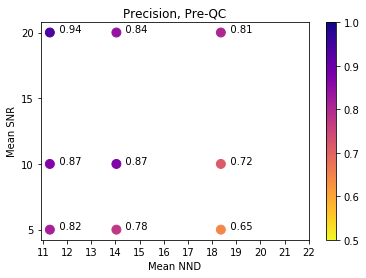

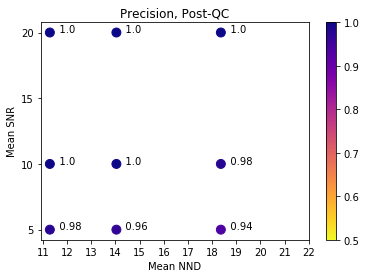

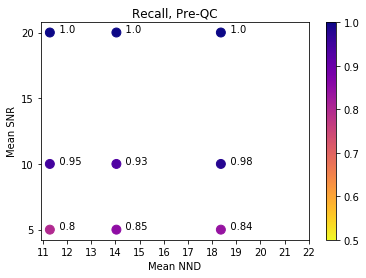

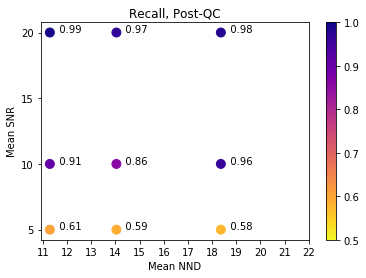

mean_precision_pre_qc_snr5 = 0.75
mean_precision_post_qc_snr5 = 0.96
mean_precision_delta_snr5 = 0.21

mean_recall_pre_qc_snr5 = 0.83
mean_recall_post_qc_snr5 = 0.59
mean_recall_delta_snr5 = -0.24

mean_precision_pre_qc_snr10 = 0.82
mean_precision_post_qc_snr10 = 0.99
mean_precision_delta_snr10 = 0.17

mean_recall_pre_qc_snr10 = 0.95
mean_recall_post_qc_snr10 = 0.91
mean_recall_delta_snr10 = -0.04

mean_precision_pre_qc_snr20 = 0.86
mean_precision_post_qc_snr20 = 1.0
mean_precision_delta_snr20 = 0.14

mean_recall_pre_qc_snr20 = 1.0
mean_recall_post_qc_snr20 = 0.98
mean_recall_delta_snr20 = -0.02


In [5]:
prefixes = ['MAX_C3-ISP', 'MAX_ISP']

# cell plots, then tissue plots
for prefix in prefixes:
    
    precision_pre_qc_list_snr5, precision_post_qc_list_snr5, recall_pre_qc_list_snr5, recall_post_qc_list_snr5 = [], [], [], []
    precision_pre_qc_list_snr10, precision_post_qc_list_snr10, recall_pre_qc_list_snr10, recall_post_qc_list_snr10 = [], [], [], []
    precision_pre_qc_list_snr20, precision_post_qc_list_snr20, recall_pre_qc_list_snr20, recall_post_qc_list_snr20 = [], [], [], []

    background = 'Cell' if prefix == 'MAX_C3-ISP' else 'Tissue'
    print('\n--------------\n%s Background\n--------------' % (background))
    
    for precision_or_recall in ['Precision', 'Recall']:
        for pre_or_post in ['pre_qc', 'post_qc']:

            # for each image
            mean_nnd_list, mean_snr_list, data_list = [], [], []
            for csv_filename in os.listdir('./datasets/SynthTest/clusters/%s' % pre_or_post):

                if csv_filename.startswith(prefix) and csv_filename.endswith('_coord_snr_list.csv'):

                    path = './datasets/SynthTest/clusters/%s/%s' % (pre_or_post, csv_filename)
                    prec_rec_snr_nnd_path = path.replace('.csv','_prec_rec_snr_nnd.csv')

                    precision, recall, mean_snr, mean_nnd = np.asarray(pd.read_csv(prec_rec_snr_nnd_path))[0]
                    mean_nnd_list.append(mean_nnd)
                    mean_snr_list.append(mean_snr)
                    data = precision if precision_or_recall == 'Precision' else recall
                    
                    data_list.append(data)
            
                    if 'snr5' in csv_filename:
                        if precision_or_recall == 'Precision' and pre_or_post == 'pre_qc':
                            precision_pre_qc_list_snr5.append(data)
                        elif precision_or_recall == 'Precision' and pre_or_post == 'post_qc':
                            precision_post_qc_list_snr5.append(data)
                        elif precision_or_recall == 'Recall' and pre_or_post == 'pre_qc':
                            recall_pre_qc_list_snr5.append(data)
                        elif precision_or_recall == 'Recall' and pre_or_post == 'post_qc':
                            recall_post_qc_list_snr5.append(data)
                    elif 'snr10' in csv_filename:
                        if precision_or_recall == 'Precision' and pre_or_post == 'pre_qc':
                            precision_pre_qc_list_snr10.append(data)
                        elif precision_or_recall == 'Precision' and pre_or_post == 'post_qc':
                            precision_post_qc_list_snr10.append(data)
                        elif precision_or_recall == 'Recall' and pre_or_post == 'pre_qc':
                            recall_pre_qc_list_snr10.append(data)
                        elif precision_or_recall == 'Recall' and pre_or_post == 'post_qc':
                            recall_post_qc_list_snr10.append(data)
                    elif 'snr20' in csv_filename:
                        if precision_or_recall == 'Precision' and pre_or_post == 'pre_qc':
                            precision_pre_qc_list_snr20.append(data)
                        elif precision_or_recall == 'Precision' and pre_or_post == 'post_qc':
                            precision_post_qc_list_snr20.append(data)
                        elif precision_or_recall == 'Recall' and pre_or_post == 'pre_qc':
                            recall_pre_qc_list_snr20.append(data)
                        elif precision_or_recall == 'Recall' and pre_or_post == 'post_qc':
                            recall_post_qc_list_snr20.append(data)
                        
            plt.figure()
            plt.scatter(mean_nnd_list, mean_snr_list, c=data_list, cmap=cm, s=80)
            for i, txt in enumerate(data_list):
                plt.annotate('   %s'%(round(txt, 2)), (mean_nnd_list[i], mean_snr_list[i]))
            s = 'Pre-QC' if pre_or_post == 'pre_qc' else 'Post-QC'
            title = '%s with %s Background, %s' % (precision_or_recall, background, s)
            plot_title = '%s, %s' % (precision_or_recall, s)
            plt.title(plot_title)
            plt.xlabel('Mean NND')
            plt.ylabel('Mean SNR')
            plt.xticks(np.arange(11, 23, 1))
            plt.yticks(np.arange(5, 25, 5))
            plt.colorbar()
            plt.clim(0.5,1)
            plt.savefig(title + '.pdf', transparent=True, bbox_inches='tight')
            plt.show()
            
    mean_precision_pre_qc_snr5 = np.mean(precision_pre_qc_list_snr5)
    mean_precision_post_qc_snr5 = np.mean(precision_post_qc_list_snr5)
    mean_recall_pre_qc_snr5 = np.mean(recall_pre_qc_list_snr5)
    mean_recall_post_qc_snr5 = np.mean(recall_post_qc_list_snr5)
    
    mean_precision_pre_qc_snr10 = np.mean(precision_pre_qc_list_snr10)
    mean_precision_post_qc_snr10 = np.mean(precision_post_qc_list_snr10)
    mean_recall_pre_qc_snr10 = np.mean(recall_pre_qc_list_snr10)
    mean_recall_post_qc_snr10 = np.mean(recall_post_qc_list_snr10)
    
    mean_precision_pre_qc_snr20 = np.mean(precision_pre_qc_list_snr20)
    mean_precision_post_qc_snr20 = np.mean(precision_post_qc_list_snr20)
    mean_recall_pre_qc_snr20 = np.mean(recall_pre_qc_list_snr20)
    mean_recall_post_qc_snr20 = np.mean(recall_post_qc_list_snr20)
            
    print('mean_precision_pre_qc_snr5 = %s' % round(mean_precision_pre_qc_snr5, 2))
    print('mean_precision_post_qc_snr5 = %s' % round(mean_precision_post_qc_snr5, 2))
    print('mean_precision_delta_snr5 = %s\n' % (round((mean_precision_post_qc_snr5 - mean_precision_pre_qc_snr5), 2)))

    print('mean_recall_pre_qc_snr5 = %s' % round(mean_recall_pre_qc_snr5, 2))
    print('mean_recall_post_qc_snr5 = %s' % round(mean_recall_post_qc_snr5, 2))
    print('mean_recall_delta_snr5 = %s\n' % (round((mean_recall_post_qc_snr5 - mean_recall_pre_qc_snr5), 2)))

    print('mean_precision_pre_qc_snr10 = %s' % round(mean_precision_pre_qc_snr10, 2))
    print('mean_precision_post_qc_snr10 = %s' % round(mean_precision_post_qc_snr10, 2))
    print('mean_precision_delta_snr10 = %s\n' % (round((mean_precision_post_qc_snr10 - mean_precision_pre_qc_snr10), 2)))

    print('mean_recall_pre_qc_snr10 = %s' % round(mean_recall_pre_qc_snr10, 2))
    print('mean_recall_post_qc_snr10 = %s' % round(mean_recall_post_qc_snr10, 2))
    print('mean_recall_delta_snr10 = %s\n' % (round((mean_recall_post_qc_snr10 - mean_recall_pre_qc_snr10), 2)))

    print('mean_precision_pre_qc_snr20 = %s' % round(mean_precision_pre_qc_snr20, 2))
    print('mean_precision_post_qc_snr20 = %s' % round(mean_precision_post_qc_snr20, 2))
    print('mean_precision_delta_snr20 = %s\n' % (round((mean_precision_post_qc_snr20 - mean_precision_pre_qc_snr20), 2)))

    print('mean_recall_pre_qc_snr20 = %s' % round(mean_recall_pre_qc_snr20, 2))
    print('mean_recall_post_qc_snr20 = %s' % round(mean_recall_post_qc_snr20, 2))
    print('mean_recall_delta_snr20 = %s' % (round((mean_recall_post_qc_snr20 - mean_recall_pre_qc_snr20), 2)))
